# Coursework: Age regression from brain MRI

Predicting the age of a patient from their brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

**The objective for the coursework is to implement two supervised learning approaches for age regression from brain MRI.** We provide data from a total of 652 healthy subjects, that is split into different development sets and a hold-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are two dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

You may find some useful ideas and implementations in the tutorial notebooks. Once you have implemented both approaches and obtained results from your experiments, we ask you to write a short summary report. The reports should contain a short introduction, description of each of your methods and the individual processing steps, your results with a brief discussion. The report should also include some figures and plots to support your findings and illustrate your results.

#### Read the text descriptions and code cells carefully and look out for the cells marked with 'TASK' and 'ADD YOUR CODE HERE'.

### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and two-fold cross-validation of age regression approaches in part A and B. **A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.**

### Install SimpleITK

In [ ]:
! pip install SimpleITK==1.2.4 

### Downloading the data

In [ ]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
! unzip brainage-data.zip

--2021-02-24 11:09:15--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 468654948 (447M) [application/zip]
Saving to: ‘brainage-data.zip’

brainage-data.zip   100%[===================>] 446.94M  1.04MB/s    in 7m 10s  

2021-02-24 11:16:26 (1.04 MB/s) - ‘brainage-data.zip’ saved [468654948/468654948]

Archive:  brainage-data.zip
   creating: data/
   creating: data/brain_age/
   creating: data/brain_age/images/
  inflating: data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110037_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110045_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110056_T1w_unbiased.nii.gz  
  inflating: data/brain_age/images/sub-CC110062_T1w_unbiased.nii.gz  
  inflating

### Setting data directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab\ Notebooks/ic_mli_cw

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/ic_mli_cw


In [ ]:
# data directory
data_dir = './data/brain_age/'
%pwd

'/content/drive/MyDrive/Colab Notebooks/ic_mli_cw'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [ ]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics.

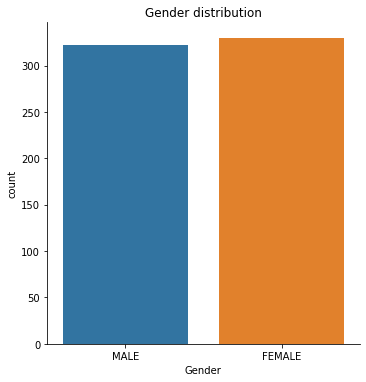

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


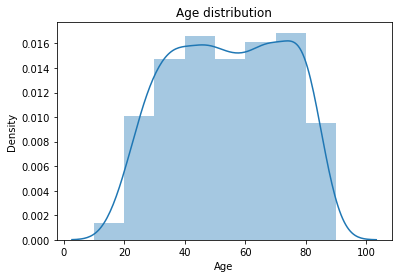

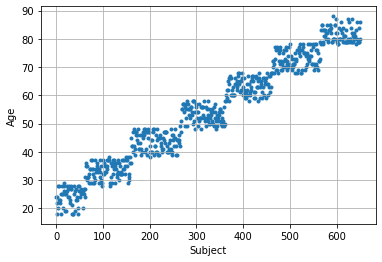

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a simple medical image viewer and import SimpleITK

In [ ]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap=colormap, clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap=colormap, clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap=colormap, clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image


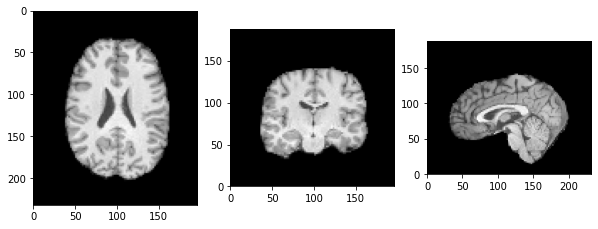

Brain mask


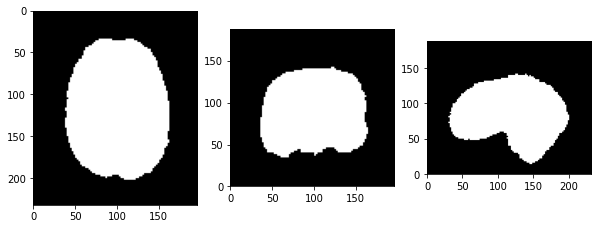

In [ ]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image')
display_image(img, window=400, level=200)

print('Brain mask')
display_image(msk)

## Part A: Age prediction using brain tissue segmentation and volume features

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain tissues include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation on the set of 500 subjects, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.

*Note:* If you struggle with task A-1, you can continue with A-2 using the provided reference segmentations in subfolder `segs_refs`.

### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations. Summarise the statistics of the 500 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).

*Note:* Implementing a full-fledged machine learning pipeline with training and testing procedures in Jupyter notebooks is a bit cumbersome and a pain to debug. Also, running bigger training tasks can be unstable. The code below should work as is. However, if you want to get a bit more serious about implementing an advanced CNN approach for image segmentation, you may want to move code into separate Python scripts and run these from the terminal or an IDE such as [PyCharm](https://www.jetbrains.com/pycharm/).

#### Imports

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import joblib

#### Data Helpers

In [ ]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]


#### Check that the GPU is up and running

In [ ]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla P100-PCIE-16GB


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

**TASK: This needs to be revisited to optimise these values. In particular, you may want to run your final model on higher resolution images.**

In [ ]:
#Our implementation
rnd_seed = 42 #fixed random seed

img_size = [128, 128, 128]
img_spacing = [1.5, 1.5, 1.5]

num_epochs = 100
learning_rate = 0.01
batch_size =4
val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

In [ ]:
#Choose if you want to run algorithm on the development or full dataset
corpus = 'full'

#Development set: 47 training examples, 5 validation examples
if corpus == 'development':
  meta_data_path_train = 'meta/meta_data_segmentation_train.csv'
  meta_data_path_val = 'meta/meta_data_segmentation_val.csv'

#Full corpus: 500 training examples, 100 validation examples
elif corpus == 'full':
  meta_data_path_train = 'meta/meta_data_regression_train.csv'
  meta_data_path_val = 'meta/meta_data_regression_test.csv'

meta_data_seg_train = pd.read_csv(data_dir + meta_data_path_train)
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + meta_data_path_val)
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**You may want to use initially the validation data with 5 subjects for training which is more efficient when debugging your training routine and model implementation. Make sure to later train your final model on the actual training data.**

In [ ]:
# LOAD TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
# FOR QUICK DEBUGGING, USE THE VALIDATION DATA FOR TRAINING
#dataset_train = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# LOAD VALIDATION DATA
dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [05:46<00:00,  3.47s/it]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC520745_T1w_unbiased.nii.gz


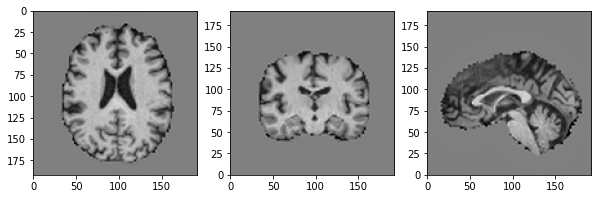

Segmentation


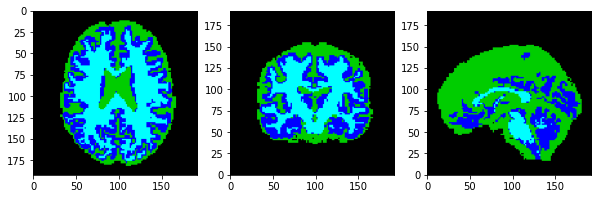

Mask


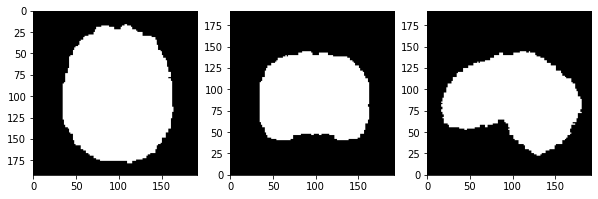

In [ ]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

In [ ]:
sample_image = next(iter(dataloader_train))
sample_image['img'] #Batch of images size [2, 1, 64, 64, 64]
sample_image['seg'] #Correct segmentations
sample_image['msk'] #Masks
print(sample_image['img'].shape)

torch.Size([4, 1, 128, 128, 128])


#### The Model

**TASK:** This is the **key part of task A-1** where you have to design a suitable CNN model for brain segmentation. The simple model provided below works to some degree (it let's you run through the upcoming cells), but it will not perform very well. Use what you learned in the lectures to come up with a good architecture. Start with a simple, shallow model and only increase complexity (e.g., number of layers) if needed.

In [ ]:
########################################
# BUILD A BETTER MODEL HERE
########################################

#Model based on a U-Net Architecture developed at University of Freiburg: https://arxiv.org/abs/1505.04597

class SimpleNet3D(nn.Module):

    def __init__(self, num_classes):
        super(SimpleNet3D, self).__init__()

        #3-4 Layers U-Net accorging to https://arxiv.org/abs/1505.04597
        #Uncomment for level 4

        #TODO: Add data augmentation
        #Shift and rotation invariance -> here probably not necessary
        #Robustnett to deformation and gray value variations -> here probably not necessary
        #Random elastic deformations

        base_size = 8

        self.enc1 = nn.Sequential(
            nn.Conv3d(1, base_size, kernel_size=3, padding=1),
            nn.BatchNorm3d(base_size),
            nn.ReLU(), 
            nn.Conv3d(base_size,base_size,kernel_size = 3,padding=1), 
            nn.BatchNorm3d(base_size),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool3d(kernel_size = 2,stride = 2)

        self.enc2 = nn.Sequential(
            nn.Conv3d(base_size, base_size * 2, kernel_size=3, padding=1),
            nn.BatchNorm3d(base_size * 2),
            nn.ReLU(), 
            nn.Conv3d(base_size * 2,base_size * 2,kernel_size = 3,padding=1), 
            nn.BatchNorm3d(base_size * 2),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool3d(kernel_size = 2, stride = 2)

        self.enc3 = nn.Sequential(
            nn.Conv3d(base_size * 2, base_size * 4, kernel_size=3, padding=1),
            nn.BatchNorm3d(base_size * 4),
            nn.ReLU(), 
            nn.Conv3d(base_size *4 ,base_size * 4,kernel_size = 3,padding=1), 
            nn.BatchNorm3d(base_size * 4),
            nn.ReLU(),
        )

        self.pool3 = nn.MaxPool3d(kernel_size = 2,stride = 2)

        self.enc4 = nn.Sequential(
           nn.Conv3d(base_size * 4, base_size * 8, kernel_size=3, padding=1),
           nn.BatchNorm3d(base_size * 8),
           nn.ReLU(), 
           nn.Conv3d(base_size *8 ,base_size * 8,kernel_size = 3,padding=1), 
           nn.BatchNorm3d(base_size * 8),
           nn.ReLU(),
        )

        self.pool4 = nn.MaxPool3d(kernel_size = 2,stride = 2)



        self.bottleneck = nn.Sequential(
            nn.Conv3d(base_size * 4,base_size * 4,kernel_size=3, padding = 1),
            nn.Conv3d(base_size * 4,base_size * 8,kernel_size = 3,padding = 1)
        )

        self.bottleneck = nn.Sequential(
            nn.Conv3d(base_size * 8,base_size * 8,kernel_size=3, padding = 1),
            nn.Conv3d(base_size * 8,base_size * 16,kernel_size = 3,padding = 1)
        )



        self.upconv4 = nn.ConvTranspose3d(base_size * 16,base_size * 8,kernel_size = 2,stride = 2)

        self.dec4 = nn.Sequential(
            nn.Conv3d(base_size * 16, base_size * 8, kernel_size=3, padding=1),
            nn.BatchNorm3d(base_size * 8),
            nn.ReLU(), 
            nn.Conv3d(base_size * 8,base_size * 8,kernel_size = 3,padding=1), 
            nn.BatchNorm3d(base_size * 8),
            nn.ReLU(),
        )




        self.upconv3 = nn.ConvTranspose3d(base_size * 8,base_size * 4,kernel_size = 2,stride = 2)


        self.dec3 = nn.Sequential(
            nn.Conv3d(base_size * 8, base_size * 4, kernel_size=3, padding=1),
            nn.BatchNorm3d(base_size * 4),
            nn.ReLU(), 
            nn.Conv3d(base_size * 4,base_size * 4,kernel_size = 3,padding=1), 
            nn.BatchNorm3d(base_size * 4),
            nn.ReLU(),
        )

        self.upconv2 = nn.ConvTranspose3d(base_size * 4,base_size * 2,kernel_size = 2,stride = 2)
     
        self.dec2 = nn.Sequential(
            nn.Conv3d(base_size * 4, base_size * 2, kernel_size=3, padding=1),
            nn.BatchNorm3d(base_size * 2),
            nn.ReLU(), 
            nn.Conv3d(base_size * 2,base_size * 2,kernel_size = 3,padding=1), 
            nn.BatchNorm3d(base_size * 2),
            nn.ReLU(),
        )

        self.upconv1 = nn.ConvTranspose3d(base_size * 2,base_size,kernel_size = 2,stride = 2)

        self.dec1 = nn.Sequential(
            nn.Conv3d(base_size * 2, base_size, kernel_size=3, padding=1),
            nn.BatchNorm3d(base_size),
            nn.ReLU(), 
            nn.Conv3d(base_size,4,kernel_size = 3,padding=1), 
            nn.BatchNorm3d(4),
            nn.ReLU(),
        )





    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))

        #bottleneck = self.bottleneck(self.pool3(enc3))
        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4,enc4),dim = 1)
        dec4 = self.dec4(dec4)
        dec3 =self.upconv3(dec4)

        #dec3 = self.upconv3(bottleneck) #comment for 4 levels
        dec3 = torch.cat((dec3,enc3),dim = 1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2,enc2), dim = 1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1,enc1), dim = 1)
        out = self.dec1(dec1)
        
        return out # cross-entropy loss expects raw logits and applies softmax

#### TRAINING

Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor Dice scores (or others).

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.363195
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.368717


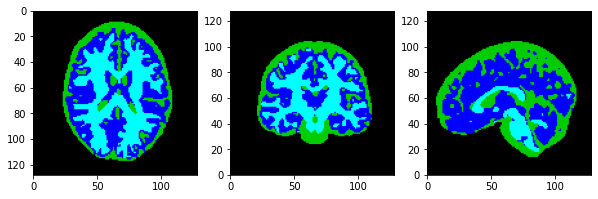

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.217358
+ TRAINING 	Epoch: 3 	Loss: 0.164437
+ TRAINING 	Epoch: 4 	Loss: 0.151387
+ TRAINING 	Epoch: 5 	Loss: 0.107889
+ TRAINING 	Epoch: 6 	Loss: 0.104014
+ TRAINING 	Epoch: 7 	Loss: 0.098519
+ TRAINING 	Epoch: 8 	Loss: 0.116743
+ TRAINING 	Epoch: 9 	Loss: 0.088738
+ TRAINING 	Epoch: 10 	Loss: 0.088939
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.090700


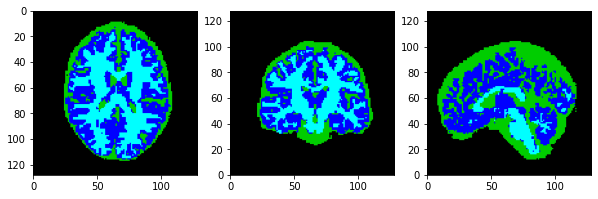

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.080618
+ TRAINING 	Epoch: 12 	Loss: 0.083721
+ TRAINING 	Epoch: 13 	Loss: 0.082837
+ TRAINING 	Epoch: 14 	Loss: 0.069124
+ TRAINING 	Epoch: 15 	Loss: 0.096231
+ TRAINING 	Epoch: 16 	Loss: 0.078510
+ TRAINING 	Epoch: 17 	Loss: 0.065173
+ TRAINING 	Epoch: 18 	Loss: 0.068203
+ TRAINING 	Epoch: 19 	Loss: 0.080980
+ TRAINING 	Epoch: 20 	Loss: 0.071939
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.081171


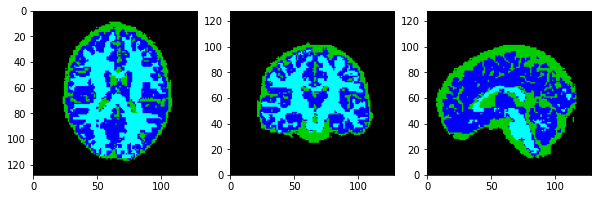

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 0.069413
+ TRAINING 	Epoch: 22 	Loss: 0.068996
+ TRAINING 	Epoch: 23 	Loss: 0.063512
+ TRAINING 	Epoch: 24 	Loss: 0.072988
+ TRAINING 	Epoch: 25 	Loss: 0.065466
+ TRAINING 	Epoch: 26 	Loss: 0.070882
+ TRAINING 	Epoch: 27 	Loss: 0.063459
+ TRAINING 	Epoch: 28 	Loss: 0.067066
+ TRAINING 	Epoch: 29 	Loss: 0.060581
+ TRAINING 	Epoch: 30 	Loss: 0.067131
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 0.071879


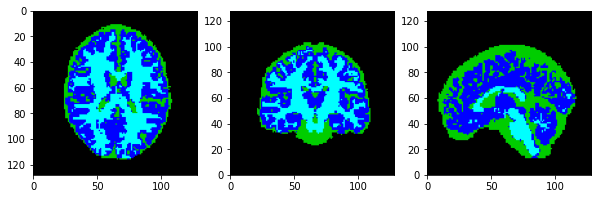

--------------------------------------------------
+ TRAINING 	Epoch: 31 	Loss: 0.059194
+ TRAINING 	Epoch: 32 	Loss: 0.053681
+ TRAINING 	Epoch: 33 	Loss: 0.061223
+ TRAINING 	Epoch: 34 	Loss: 0.058752
+ TRAINING 	Epoch: 35 	Loss: 0.060952
+ TRAINING 	Epoch: 36 	Loss: 0.055485
+ TRAINING 	Epoch: 37 	Loss: 0.062549
+ TRAINING 	Epoch: 38 	Loss: 0.060985
+ TRAINING 	Epoch: 39 	Loss: 0.063326
+ TRAINING 	Epoch: 40 	Loss: 0.057546
--------------------------------------------------
+ VALIDATE 	Epoch: 40 	Loss: 0.067857


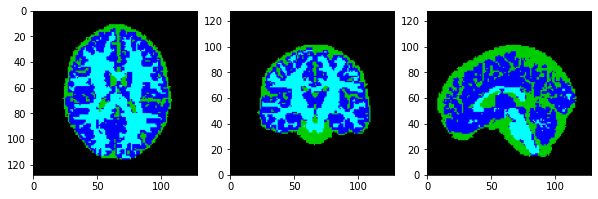

--------------------------------------------------
+ TRAINING 	Epoch: 41 	Loss: 0.060743
+ TRAINING 	Epoch: 42 	Loss: 0.055728
+ TRAINING 	Epoch: 43 	Loss: 0.053145
+ TRAINING 	Epoch: 44 	Loss: 0.054235
+ TRAINING 	Epoch: 45 	Loss: 0.057609
+ TRAINING 	Epoch: 46 	Loss: 0.057171
+ TRAINING 	Epoch: 47 	Loss: 0.054646
+ TRAINING 	Epoch: 48 	Loss: 0.065472
+ TRAINING 	Epoch: 49 	Loss: 0.056388
+ TRAINING 	Epoch: 50 	Loss: 0.064914
--------------------------------------------------
+ VALIDATE 	Epoch: 50 	Loss: 0.064807


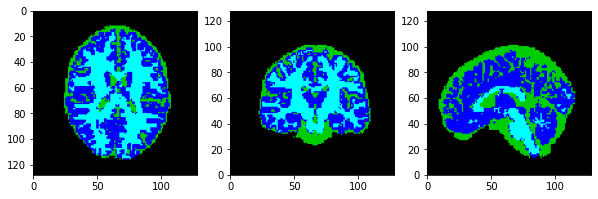

--------------------------------------------------
+ TRAINING 	Epoch: 51 	Loss: 0.047214
+ TRAINING 	Epoch: 52 	Loss: 0.049800
+ TRAINING 	Epoch: 53 	Loss: 0.057526
+ TRAINING 	Epoch: 54 	Loss: 0.058575
+ TRAINING 	Epoch: 55 	Loss: 0.054788
+ TRAINING 	Epoch: 56 	Loss: 0.051200
+ TRAINING 	Epoch: 57 	Loss: 0.052407
+ TRAINING 	Epoch: 58 	Loss: 0.046512
+ TRAINING 	Epoch: 59 	Loss: 0.061458
+ TRAINING 	Epoch: 60 	Loss: 0.045220
--------------------------------------------------
+ VALIDATE 	Epoch: 60 	Loss: 0.060465


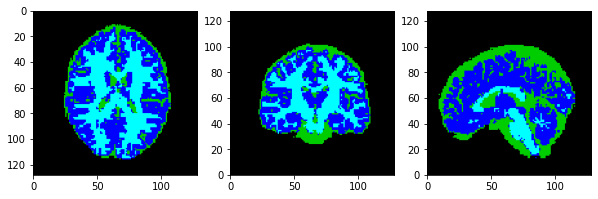

--------------------------------------------------
+ TRAINING 	Epoch: 61 	Loss: 0.056453
+ TRAINING 	Epoch: 62 	Loss: 0.060663
+ TRAINING 	Epoch: 63 	Loss: 0.051313
+ TRAINING 	Epoch: 64 	Loss: 0.051772
+ TRAINING 	Epoch: 65 	Loss: 0.049545
+ TRAINING 	Epoch: 66 	Loss: 0.047558
+ TRAINING 	Epoch: 67 	Loss: 0.051040
+ TRAINING 	Epoch: 68 	Loss: 0.046437
+ TRAINING 	Epoch: 69 	Loss: 0.050570
+ TRAINING 	Epoch: 70 	Loss: 0.044910
--------------------------------------------------
+ VALIDATE 	Epoch: 70 	Loss: 0.059200


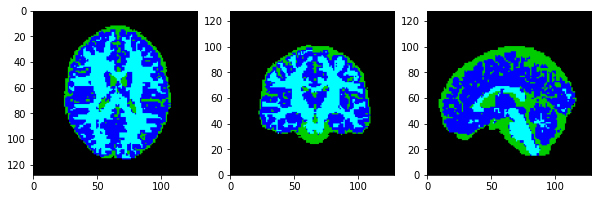

--------------------------------------------------
+ TRAINING 	Epoch: 71 	Loss: 0.047971
+ TRAINING 	Epoch: 72 	Loss: 0.043939
+ TRAINING 	Epoch: 73 	Loss: 0.051876
+ TRAINING 	Epoch: 74 	Loss: 0.050151
+ TRAINING 	Epoch: 75 	Loss: 0.045724
+ TRAINING 	Epoch: 76 	Loss: 0.051749
+ TRAINING 	Epoch: 77 	Loss: 0.043887
+ TRAINING 	Epoch: 78 	Loss: 0.052304
+ TRAINING 	Epoch: 79 	Loss: 0.052034
+ TRAINING 	Epoch: 80 	Loss: 0.045584
--------------------------------------------------
+ VALIDATE 	Epoch: 80 	Loss: 0.057486


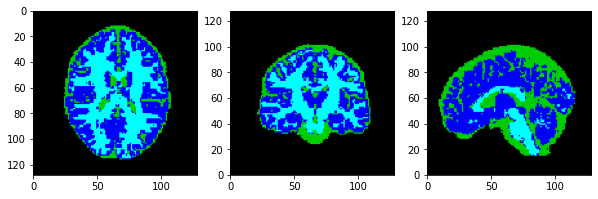

--------------------------------------------------
+ TRAINING 	Epoch: 81 	Loss: 0.047820
+ TRAINING 	Epoch: 82 	Loss: 0.055350
+ TRAINING 	Epoch: 83 	Loss: 0.043479
+ TRAINING 	Epoch: 84 	Loss: 0.046363
+ TRAINING 	Epoch: 85 	Loss: 0.053714
+ TRAINING 	Epoch: 86 	Loss: 0.045686
+ TRAINING 	Epoch: 87 	Loss: 0.045629
+ TRAINING 	Epoch: 88 	Loss: 0.043561
+ TRAINING 	Epoch: 89 	Loss: 0.047629
+ TRAINING 	Epoch: 90 	Loss: 0.054424
--------------------------------------------------
+ VALIDATE 	Epoch: 90 	Loss: 0.056980


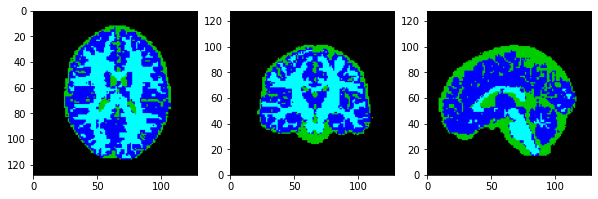

--------------------------------------------------
+ TRAINING 	Epoch: 91 	Loss: 0.044908
+ TRAINING 	Epoch: 92 	Loss: 0.046301
+ TRAINING 	Epoch: 93 	Loss: 0.043358
+ TRAINING 	Epoch: 94 	Loss: 0.041832
+ TRAINING 	Epoch: 95 	Loss: 0.047806
+ TRAINING 	Epoch: 96 	Loss: 0.045894
+ TRAINING 	Epoch: 97 	Loss: 0.057360
+ TRAINING 	Epoch: 98 	Loss: 0.050696
+ TRAINING 	Epoch: 99 	Loss: 0.043644
+ TRAINING 	Epoch: 100 	Loss: 0.044167
--------------------------------------------------
+ VALIDATE 	Epoch: 100 	Loss: 0.056513


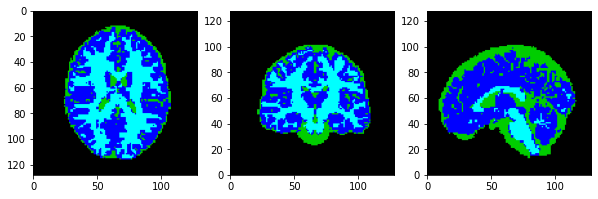

--------------------------------------------------

Finished TRAINING.


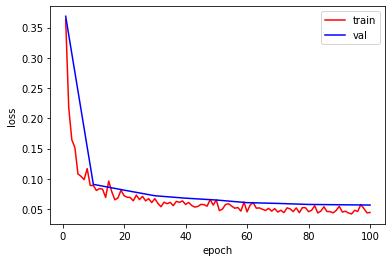

In [ ]:
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

model = SimpleNet3D(num_classes=num_classes).to(device)
model.train()
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        loss = F.cross_entropy(prd, seg.squeeze(1))
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    
    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                loss_val += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
                sum_pts += np.prod(img_size)
                
        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        

        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Loss Curves - Learning Rate: 0.01, Batch Size: 4, Image Size: 128, Image Spacing: 1.5


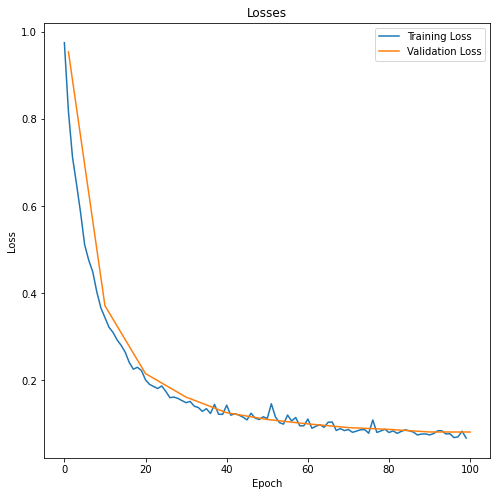

In [ ]:

print("Loss Curves - Learning Rate: {}, Batch Size: {}, Image Size: {}, Image Spacing: {}".format(learning_rate,batch_size,img_size[0],img_spacing[0]))

#Plotting the loss curve of our segmentation
from matplotlib import pyplot as plt
import numpy as np

x = np.arange(len(loss_train_log))

fig = plt.figure(figsize=(8,8))
ax = plt.axes()
#plt.yscale("log")

plt.plot(x,loss_train_log,label = 'Training Loss')
plt.plot(epoch_val_log,loss_val_log,label = 'Validation Loss')

plt.title("Losses")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()
plt.close()

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. Note, at a later stage you will also need to run the model on the 100 subjects from the hold-out set, once these have been made available. Before testing on the full set, you may want to initially just test on the 5 validation subjects to check everything is working fine.

In [ ]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])


files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 500/500 [05:07<00:00,  1.63it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC520745_T1w_unbiased.nii.gz


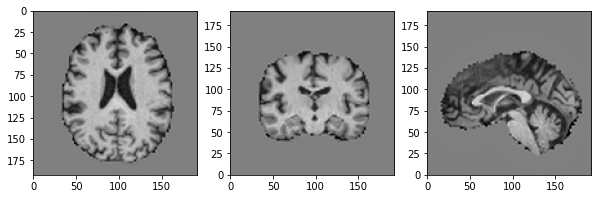

Segmentation


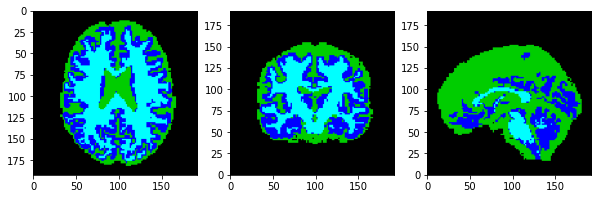

Mask


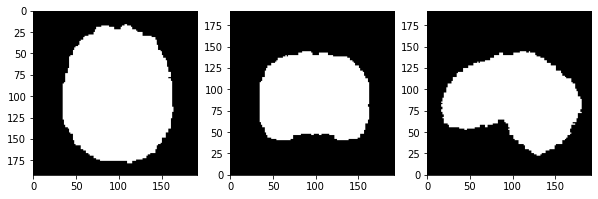

In [ ]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.

**TASK: You will need to add the calculations of Dice scores (and possibly other metrics) to evaluate the segmentation performance.**

In [ ]:
###### OUR IMPLEMENTATION #############

#Dice coefficient from https://discuss.pytorch.org/t/calculating-dice-coefficient/44154
def dice_coeff(pred, target):
    num = pred.size(0)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    intersection = (m1 == m2).sum().float()

    return ((2 * intersection) / (m1.shape[1] + m2.shape[1])).item()

START TESTING...
+ TESTING 	Loss: 0.046592


Reference segmentation


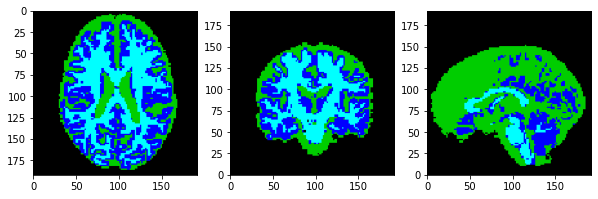

Predicted segmentation


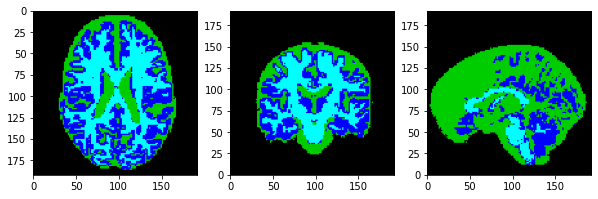


Finished TESTING.
Dice: 0.9803019380569458


In [ ]:
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model_dir = os.path.join(out_dir, 'model')

model = SimpleNet3D(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0

dice = 0

with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        loss_test += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
        sum_pts += np.prod(img_size)

        prd = torch.argmax(prd, dim=1)
        dice += dice_coeff(prd,seg)


        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        
        idx_test += 1
        
loss_test /= sum_pts
dice /= len(dataloader_test)

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

print("Dice: {}".format(dice))

### TASK A-2: Feature calculation

Start by calculating the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.

*Note:* If you are struggling with the previous task on image segmentation, or if you prefer to work on this and the following tasks first, you can continue here using the provided reference segmentations which can be found in a subfolder `segs_refs`.

In [ ]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os
import pickle

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = './output/pred/'

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
#seg_dir = data_dir + 'segs_refs/'

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_train)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        
        ########################################
        # ADD YOUR CODE HERE
        ########################################
        img_array = sitk.GetArrayFromImage(seg)
        vols[:,idx] = np.unique(img_array,return_counts= True)[1][1:]

pickle.dump( vols, open( "vols.p", "wb" ) )


Calculating Features: 100%|██████████| 500/500 [00:24<00:00, 20.25it/s]


In [ ]:
#Pickle data to avoid retraining
import pickle
vols = pickle.load(open( "vols.p", "rb" ))

Plot features versus age.

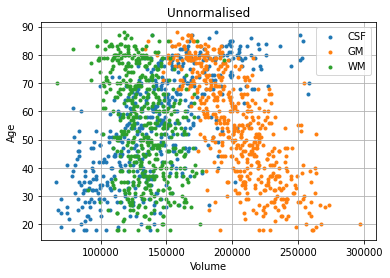

In [ ]:
plt.scatter(vols[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

In [ ]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised = np.zeros((3,len(files_reg_seg_train)))

########################################
# ADD YOUR CODE HERE
########################################
vols_normalised = vols /  vols.sum(axis = 0)
vols_normalised

array([[0.33279788, 0.34609587, 0.41996668, ..., 0.30631462, 0.26864753,
        0.31699736],
       [0.39383936, 0.39295564, 0.34610567, ..., 0.40890418, 0.46016214,
        0.41357372],
       [0.27336275, 0.2609485 , 0.23392765, ..., 0.28478121, 0.27119033,
        0.26942891]])

Plot normalised features versus age.

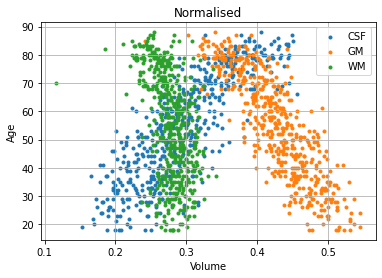

In [ ]:
plt.scatter(vols_normalised[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.show()

Final data for age regression

In [ ]:
X = vols_normalised.T
y = meta_data_reg_train['age'].values.reshape(-1,1)

print(X.shape)
print(y.shape)

(500, 3)
(500, 1)


### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Remember to construct the output vectur $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).

Try using at least three different regression methods, and generate a plot allows easy comparison of the performance of the three methods. Useful [error metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) to report include mean absolute error and r2 score. You might also want to plot the real vs predicted ages.

*Note:* These [scikit-learn examples](https://scikit-learn.org/stable/auto_examples/) might serve as an inspiration.

*Hint:* Be careful how you split the dataset into two folds. Take into account the data characteristics shown at the top of the notebook.

In [ ]:
#We augment the data to boost performance
# 1. Combining features
# 2. Adding gender as feature

def augment_data(X,meta_data_reg_train):

  X_aug = np.zeros((X.shape[0],11))
  X_aug[:,0:3] = X
  X_aug[:,3] = meta_data_reg_train['gender_code']
  X_aug[:,4] = X[:,0] ** 2
  X_aug[:,5] = X[:,1] ** 2
  X_aug[:,6] = X[:,2] ** 2
  X_aug[:,6] = X[:,0] * X[:,1]
  X_aug[:,7] = X[:,1] * X[:,2]
  X_aug[:,8] = X[:,0] * X[:,2]
  X_aug[:,9] = X[:,0] * X[:,1] * X[:,2] 


  return X_aug


In [ ]:
########################################
# ADD YOUR CODE HERE
########################################
from sklearn.model_selection import train_test_split
from sklearn import svm,tree
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold

folds = 2

#Augment inputs
X_aug = augment_data(X,meta_data_reg_train)

#Normalize Inputs
scaler = preprocessing.StandardScaler().fit(X_aug)
X_processed = scaler.transform(X_aug)

#Strattified Split makes sure each age group is approximately equally represented in each fold -> boosts performance
skf = StratifiedKFold(n_splits = 2,shuffle = True)
skf.get_n_splits(X_processed,y)


#x1,x2,y1,y2 = train_test_split(X_processed,y,test_size = 0.5, random_state = 42,shuffle = True)
#y_true = np.concatenate((y2,y1),axis = 0)
#print(x1.shape)
#print(y1.shape)

2

In [13]:
from sklearn.metrics import r2_score

In [ ]:
#Function to test different models
def test_model(skf,model,X,y):

  assert(X.shape[0] == y.shape[0])

  predicted = np.empty((y.shape[0],1))

  for train_index,test_index in skf.split(X,y):

    model.fit(X[train_index],y[train_index])
    predicted[test_index] = model.predict(X[test_index]).reshape((-1,1))
  
  return predicted

In [ ]:
#Evaluation function
def evaluate(y,predicted):

  print('MSE: {0}'.format(mean_squared_error(y,predicted)))
  print('MAE: {0}'.format(mean_absolute_error(y,predicted)))
  print('R2: {0}'.format(r2_score(y,predicted)))

  fig, ax = plt.subplots()
  ax.scatter(y, predicted, marker='.')
  ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
  ax.set_xlabel('Real Age')
  ax.set_ylabel('Predicted Age')
  plt.show()

MSE: 107.93022222222221
MAE: 8.113333333333333
R2: 0.6101233806667681


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)


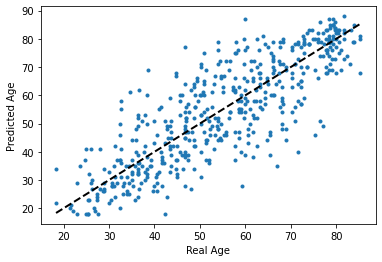

In [ ]:
#Nearest Neighbor Regression
nn_model = KNeighborsRegressor(n_neighbors=3)
prediction = test_model(skf,nn_model,X_processed,y)
evaluate(prediction,y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE: 106.15508964926758
MAE: 8.363146794241768
R2: 0.3600334806206661


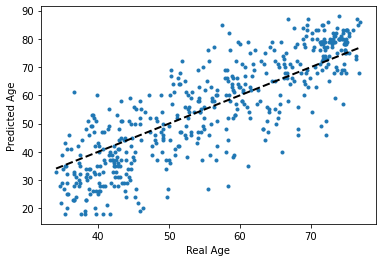

In [ ]:
#SVM Regression
svm_model = svm.SVR()
prediction = test_model(skf,svm_model,X_processed,y)
evaluate(prediction,y)

Error calculation and plotting

MSE: 185.852
MAE: 10.408
R2: 0.44855706041070875


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)


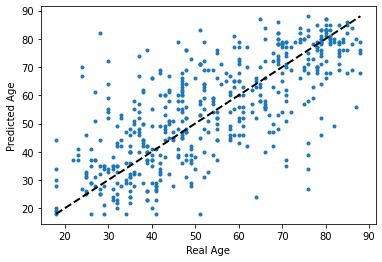

In [ ]:
#Decision Tree MRegression
dt_model = tree.DecisionTreeRegressor()
prediction = test_model(skf,dt_model,X_processed,y)
evaluate(prediction,y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE: 83.00121217529951
MAE: 7.03387225650276
R2: 0.6872828571655291


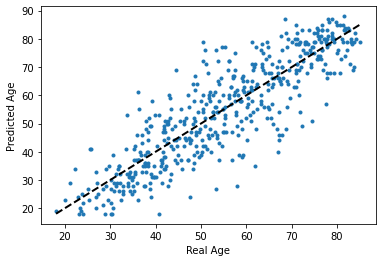

In [ ]:
#Multilayer Perceptron Regression
mlp_model = MLPRegressor(hidden_layer_sizes=(50,20,10),learning_rate_init = 0.05,random_state = 0,solver = 'adam',max_iter = 200,alpha = 0.001)
prediction = test_model(skf,mlp_model,X_processed,y)
evaluate(prediction,y)

In [ ]:
#The Multilayer perceptron is the best model so we take this as our final model 
import joblib
joblib.dump(mlp_model, "part1_model.sav")


['part1_model.sav']

### Task A-4: Final test on hold-out data

#### Downloading data

This is only available once the final test data has been released.

In [ ]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-testdata.zip
! unzip brainage-testdata.zip

--2021-02-24 13:16:25--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-testdata.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1521 (1.5K) [application/zip]
Saving to: ‘brainage-testdata.zip’

brainage-testdata.z 100%[===================>]   1.49K  --.-KB/s    in 0s      

2021-02-24 13:16:28 (203 MB/s) - ‘brainage-testdata.zip’ saved [1521/1521]

Archive:  brainage-testdata.zip
  inflating: data/brain_age/meta/meta_data_regression_test.csv  


#### Loading and pre-processing of testing data

In [ ]:
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_seg_test = list(meta_data_reg_test['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


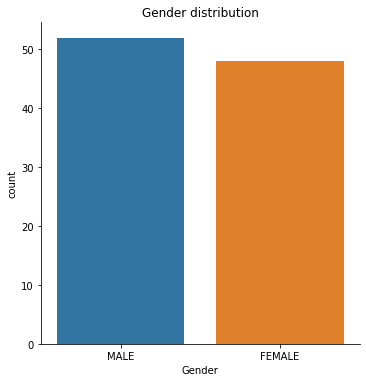

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


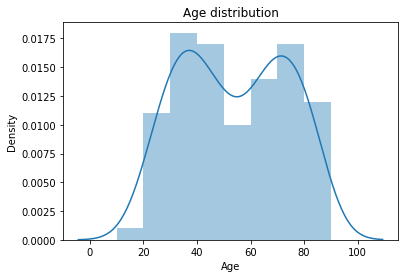

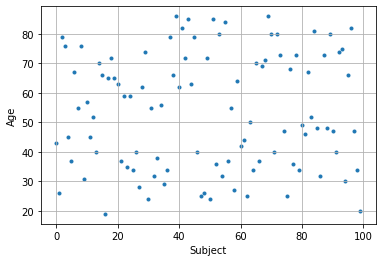

In [ ]:
#Exploring Test Data
# Checking if it has the same distribution as the training data
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

meta_data = meta_data_reg_test

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10,20,30,40,50,60,70,80,90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])),meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

#### Run final testing

START SEGMENTATION OF TESTDATA...
+ TESTING 	Loss: 0.054144


Reference segmentation


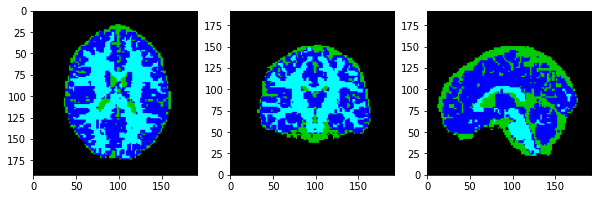

Predicted segmentation


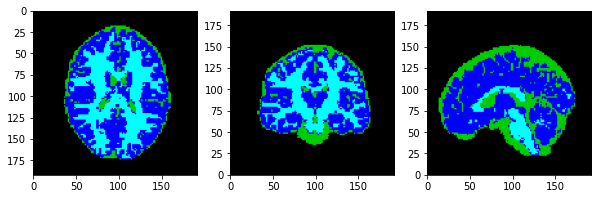


Finished SEGMENTATION.
Dice: 0.9775126457214356


In [ ]:
########################################
# ADD YOUR CODE HERE
########################################

#Directory to save testdata
test_dir = os.path.join(out_dir, 'test')
if not os.path.exists(test_dir):
    os.makedirs(test_dir)


#We use our previously trained segmentation model to perform a segmentation on the test data
model_dir = os.path.join(out_dir, 'model')
model = SimpleNet3D(num_classes=num_classes)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()


print('START SEGMENTATION OF TESTDATA...')

loss_test = 0
sum_pts = 0
idx_test = 0

dice = 0

with torch.no_grad():
    for data_sample in dataloader_test:
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        loss_test += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
        sum_pts += np.prod(img_size)

        prd = torch.argmax(prd, dim=1)
        dice += dice_coeff(prd,seg)


        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(test_dir, name))
        
        idx_test += 1
        
loss_test /= sum_pts
dice /= len(dataloader_test)

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished SEGMENTATION.')

print("Dice: {}".format(dice))
  





In [ ]:
#Compute tissue volumes from these segmentations
import os

seg_dir = './output/test/'


meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_reg_test = list(meta_data_reg_test['subject_id'])
files_reg_seg_test = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_test]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols_test = np.zeros((3,len(files_reg_seg_test)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_test)), desc='Calculating Features')):
    
    seg_filename = files_reg_seg_test[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        
        #Computes the volumes with the help of our segmentation
        img_array = sitk.GetArrayFromImage(seg)
        vols_test[:,idx] = np.unique(img_array,return_counts= True)[1][1:]


Calculating Features: 100%|██████████| 100/100 [00:05<00:00, 18.21it/s]


In [ ]:
#We compute the relative tissue volume

vols_normalised = np.zeros((3,len(files_reg_seg_test)))

#Normalizing data
vols_test_normalised = vols_test /  vols_test.sum(axis = 0)
vols_test_normalised

#Creating our dataset
X_test = vols_test_normalised.T
y_test = meta_data_reg_test['age'].values.reshape(-1,1)

print("Dataset shape:")
print(X_test.shape)
print(y_test.shape)

#Augment as training set
X_test_aug = augment_data(X_test,meta_data_reg_test)

#Use training set scaler to normalize
X_test_processed = scaler.transform(X_test_aug)

print("Augmented testset shape:")
print(X_test_processed.shape)

Dataset shape:
(100, 3)
(100, 1)
Augmented testset shape:
(100, 11)


MSE: 68.35406522397285
MAE: 6.647318425566247
R2: 0.8192427336489909


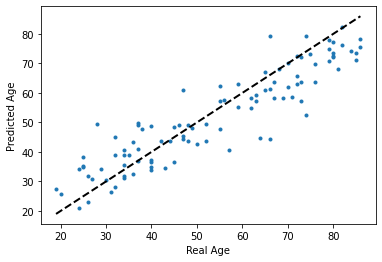

In [ ]:
#We load our best performing model and perform a prediction on the testset
predicted_test = np.empty((X_test_processed.shape[0],1))

final_model = joblib.load("part1_model.sav")
predicted_test = final_model.predict(X_test_processed).reshape((X_test_processed.shape[0],1))

evaluate(y_test,predicted_test)

## Part B: Age prediction using regression CNNs

For the second approach we will use a convolutional neural network to directly predict a subject's age.

You will need to implement a CNN model that takes an MRI scan as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from previous tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to task A. For the final age prediction model, you should use all 500 subjects for training and you may want to use the 47 subjects that we used for training the tissue segmentation model as your validation data.

*Note:* Similar to task A, you may want to set up a pre-processing pipeline that involves intensity normalisation and resampling of the input data.

In [23]:
! pip install SimpleITK==1.2.4 

In [24]:
import pandas as pd
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import joblib

In [25]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))   

Device: cuda:0
GPU: Tesla V100-SXM2-16GB


In [26]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab\ Notebooks/ic_mli_cw

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/ic_mli_cw


In [27]:
torch.manual_seed(42) #fixed random seed

img_size = [128, 128, 128]
img_spacing = [1.5, 1.5, 1.5]

num_epochs = 100
learning_rate = 0.01
batch_size = 16
val_interval = 10

n_splits = 3

out_dir = './output'

# data directory
data_dir = './data/brain_age/'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [28]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array>0])
    std = np.std(img_array[msk_array>0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array==0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


### AUGMENTED IMAGE SEGMENTATION DATASET WITH AGE ### 
class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, 
                 patient_age, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        self.patient_ages = []

        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            age = patient_age[idx]

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk, 'age': age} # added age as a key

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))
            self.patient_ages.append(age) # appended age variable for iter

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)
        age = sample['age']

        return {'img': image, 'seg': seg, 'msk': msk, 'age': age}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]
    
    def get_patient_age(self, item):
        # Returns the patient with the age
        return self.patient_ages[item]

In [29]:
 # Set up files

corpus = 'development'

#Development set: 47 training examples, 5 validation examples
if corpus == 'development':
  meta_data_path_train = 'meta/meta_data_segmentation_train.csv'
  meta_data_path_test = 'meta/meta_data_segmentation_val.csv'

#Full corpus: 500 training examples, 100 validation examples
elif corpus == 'full':
  meta_data_path_train = 'meta/meta_data_regression_train.csv'
  meta_data_path_test = 'meta/meta_data_regression_test.csv'





meta_data_seg_train = pd.read_csv(data_dir + meta_data_path_train)
ids_seg_train = list(meta_data_seg_train['subject_id'])
patient_ages_train = meta_data_seg_train['age'] # retrieve patient ages
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + meta_data_path_test)
ids_seg_val = list(meta_data_seg_val['subject_id'])
patient_ages_val = meta_data_seg_val['age'] # retrieve patient ages
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]


In [30]:
########################################
# BUILD A BETTER MODEL HERE
########################################

#Approach 1: U-Net with an additional regression layer on top to predict age


class Regression_Net1(nn.Module):

    def __init__(self,image_size):
        super(Regression_Net1, self).__init__()

        #3-4 Layers U-Net accorging to https://arxiv.org/abs/1505.04597
        #Uncomment for level 4

        #TODO: Add data augmentation
        #Shift and rotation invariance -> here probably not necessary
        #Robustnett to deformation and gray value variations -> here probably not necessary
        #Random elastic deformations

        base_size = 8
        self.image_size = image_size

        self.enc1 = nn.Sequential(
            nn.Conv3d(1, base_size, kernel_size=3, padding=1),
            nn.BatchNorm3d(base_size),
            nn.ReLU(), 
            nn.Conv3d(base_size,base_size,kernel_size = 3,padding=1), 
            nn.BatchNorm3d(base_size),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool3d(kernel_size = 2,stride = 2)

        self.enc2 = nn.Sequential(
            nn.Conv3d(base_size, base_size * 2, kernel_size=3, padding=1),
            nn.BatchNorm3d(base_size * 2),
            nn.ReLU(), 
            nn.Conv3d(base_size * 2,base_size * 2,kernel_size = 3,padding=1), 
            nn.BatchNorm3d(base_size * 2),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool3d(kernel_size = 2, stride = 2)

        self.enc3 = nn.Sequential(
            nn.Conv3d(base_size * 2, base_size * 4, kernel_size=3, padding=1),
            nn.BatchNorm3d(base_size * 4),
            nn.ReLU(), 
            nn.Conv3d(base_size *4 ,base_size * 4,kernel_size = 3,padding=1), 
            nn.BatchNorm3d(base_size * 4),
            nn.ReLU(),
        )

        self.pool3 = nn.MaxPool3d(kernel_size = 2,stride = 2)

        self.enc4 = nn.Sequential(
           nn.Conv3d(base_size * 4, base_size * 8, kernel_size=3, padding=1),
           nn.BatchNorm3d(base_size * 8),
           nn.ReLU(), 
           nn.Conv3d(base_size *8 ,base_size * 8,kernel_size = 3,padding=1), 
           nn.BatchNorm3d(base_size * 8),
           nn.ReLU(),
        )

        self.pool4 = nn.MaxPool3d(kernel_size = 2,stride = 2)



        self.bottleneck = nn.Sequential(
            nn.Conv3d(base_size * 4,base_size * 4,kernel_size=3, padding = 1),
            nn.Conv3d(base_size * 4,base_size * 8,kernel_size = 3,padding = 1)
        )

        #self.bottleneck = nn.Sequential(
        #   nn.Conv3d(base_size * 8,base_size * 8,kernel_size=3, padding = 1),
        #   nn.Conv3d(base_size * 8,base_size * 16,kernel_size = 3,padding = 1)
        #)



        self.upconv4 = nn.ConvTranspose3d(base_size * 16,base_size * 8,kernel_size = 2,stride = 2)

        self.dec4 = nn.Sequential(
            nn.Conv3d(base_size * 16, base_size * 8, kernel_size=3, padding=1),
            nn.BatchNorm3d(base_size * 8),
            nn.ReLU(), 
            nn.Conv3d(base_size * 8,base_size * 8,kernel_size = 3,padding=1), 
            nn.BatchNorm3d(base_size * 8),
            nn.ReLU(),
        )




        self.upconv3 = nn.ConvTranspose3d(base_size * 8,base_size * 4,kernel_size = 2,stride = 2)


        self.dec3 = nn.Sequential(
            nn.Conv3d(base_size * 8, base_size * 4, kernel_size=3, padding=1),
            nn.BatchNorm3d(base_size * 4),
            nn.ReLU(), 
            nn.Conv3d(base_size * 4,base_size * 4,kernel_size = 3,padding=1), 
            nn.BatchNorm3d(base_size * 4),
            nn.ReLU(),
        )

        self.upconv2 = nn.ConvTranspose3d(base_size * 4,base_size * 2,kernel_size = 2,stride = 2)
     
        self.dec2 = nn.Sequential(
            nn.Conv3d(base_size * 4, base_size * 2, kernel_size=3, padding=1),
            nn.BatchNorm3d(base_size * 2),
            nn.ReLU(), 
            nn.Conv3d(base_size * 2,base_size * 2,kernel_size = 3,padding=1), 
            nn.BatchNorm3d(base_size * 2),
            nn.ReLU(),
        )

        self.upconv1 = nn.ConvTranspose3d(base_size * 2,base_size,kernel_size = 2,stride = 2)

        self.dec1 = nn.Sequential(
            nn.Conv3d(base_size * 2, base_size, kernel_size=3, padding=1),
            nn.BatchNorm3d(base_size),
            nn.ReLU(), 
            nn.Conv3d(base_size,1,kernel_size = 3,padding=1), 
            nn.ReLU()
        )

        self.linear = nn.Sequential(
            nn.Linear(in_features= self.image_size ** 3,out_features=self.image_size),
            nn.ReLU(),
            nn.Linear(in_features= self.image_size,out_features=1)
        )





    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool3(enc3))
        #bottleneck = self.bottleneck(self.pool4(enc4))

        #dec4 = self.upconv4(bottleneck)
        #dec4 = torch.cat((dec4,enc4),dim = 1)
        #dec4 = self.dec4(dec4)
        #dec3 =self.upconv3(dec4)

        dec3 = self.upconv3(bottleneck) #comment for 4 levels
        dec3 = torch.cat((dec3,enc3),dim = 1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2,enc2), dim = 1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1,enc1), dim = 1)
        dec1 = self.dec1(dec1)
        out = self.linear(dec1.reshape((x.shape[0],-1)))
        
        return out # cross-entropy loss expects raw logits and applies softmax

In [31]:
#Model definition

#Approach 2: Based on AlexNet, extended to 3D


class AlexNet3D(nn.Module):

    def __init__(self,image_size):
        super(AlexNet3D, self).__init__()

        self.image_size = image_size

        self.features = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2),
            nn.Conv3d(8, 16, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2),
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool3d((6,6,6))
        self.regressor = nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.image_size * 2 * 6 * 6 * 6, 1028),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1028, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.regressor(x)
        return x

In [32]:
#Model definition

#Approach 3: ResNet (18) implementation

class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.num_layers = num_layers
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.conv3 = nn.Conv3d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

class ResNet18(nn.Module):
    def __init__(self, block, image_channels, num_classes):
        super(ResNet18, self).__init__()
        self.num_layers = 18
        layers = [2, 2, 2, 2]
        self.in_channels = 64
        self.conv1 = nn.Conv3d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout3d(0.3)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(self.num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(self.num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(self.num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(self.num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1,1, 1))
        self.fc = nn.Linear(512, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv3d(self.in_channels, intermediate_channels, kernel_size=1, stride=stride),
                                            nn.BatchNorm3d(intermediate_channels))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)
        return nn.Sequential(*layers)

In [33]:
#model = Regression_Net1().to(device)
#model = AlexNet3D(64).to(device)
model = ResNet18(Block,1,1).to(device)


params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
#print(model)
print('\n')

Total number of parameters is: 15595329




In [34]:
from sklearn.model_selection import StratifiedKFold
from  sklearn.metrics import r2_score
import numpy as np

# Perform K-Fold Split into 3
skf = StratifiedKFold(n_splits = n_splits,shuffle = True)
split = list(skf.split(files_seg_img_train, patient_ages_train))

files_seg_img, files_seg_seg, files_seg_msk, patient_ages = np.asarray(files_seg_img_train), np.asarray(files_seg_seg_train), np.asarray(files_seg_msk_train), np.asarray(patient_ages_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


In [35]:
#Train and Eval
  
loss_train_log = {}
loss_val_log = {}
epoch_val_log = {}
    
print('START TRAINING...')

for s in range(n_splits):
  print("++.TRAINING WITH SPLIT {} ++".format(s+1))

  loss_train_log[s] = []
  loss_val_log[s] = []
  epoch_val_log[s] = []

  #Reset model weights between folds to avoid leakage
  for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()
  
  #Reset optimizer and scheduler for each fold
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size = 10, gamma = 0.1)

  #Get trian and test indexes
  set1_indices, set2_indices = next(iter(split))

  files_seg_img_train, files_seg_seg_train, files_seg_msk_train, patient_ages_train = list(files_seg_img[set1_indices]), list(files_seg_seg[set1_indices]), list(files_seg_msk[set1_indices]), list(patient_ages[set1_indices])
  files_seg_img_val, files_seg_seg_val, files_seg_msk_val,  patient_ages_val = list(files_seg_img[set2_indices]), list(files_seg_seg[set2_indices]), list(files_seg_msk[set2_indices]), list(patient_ages[set2_indices])

  dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train,
                                           files_seg_msk_train, patient_ages_train, img_spacing, img_size)

  dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val,
                                           files_seg_msk_val, patient_ages_val, img_spacing, img_size)

  #Get dataloaders
  dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False) 


  for epoch in range(1, num_epochs + 1):
      model.train()
      # Training

      loss_train_mse = 0
      loss_train_mae = 0
      loss_train_r2 = 0

      for batch_idx, batch_sample in enumerate(dataloader_train):
          
          batch_images = batch_sample['img']
          batch_targets = batch_sample['age'].float()
          batch_images = batch_images.to(device)
          batch_targets = batch_targets.to(device)
          
          optimizer.zero_grad()
          predictions = model(batch_images)

          loss_mse = F.mse_loss(predictions, batch_targets.reshape((-1,1)))
          loss_mae = F.l1_loss(predictions.detach(), batch_targets.reshape((-1,1)))  
          loss_r2 = r2_score(batch_targets.reshape((-1,1)).cpu().numpy(),predictions.detach().cpu().numpy())   

          loss_mse.backward()
          optimizer.step()

          loss_train_mse += loss_mse.item()
          loss_train_mae += loss_mae.item()
          loss_train_r2 += loss_r2.item()

      scheduler.step() 

      loss_train_mse /= len(dataloader_train)
      loss_train_mae /= len(dataloader_train)
      loss_train_r2 /= len(dataloader_train)

      loss_train_log[s].append((loss_train_mse,loss_train_mae))

      print('+ TRAINING SPLIT {} \tEpoch: {} \tLoss MSE: {:.6f} \tLoss MAE: {:.6f} \tR2: {:.6f}'.format(s+1, epoch, loss_train_mse,loss_train_mae,loss_train_r2))
      
      # Validation
      model.eval()
      if epoch == 1 or epoch % val_interval == 0:
          loss_val_mse = 0
          loss_val_mae = 0
          loss_val_r2 = 0

          with torch.no_grad():
              for data_sample in dataloader_val:
                  images = data_sample['img']
                  targets = data_sample['age'].float()
                  images = images.to(device)
                  targets = targets.to(device)

                  predictions = model(images)
                  loss_val_mse += F.mse_loss(predictions, targets.reshape((-1,1))).cpu().numpy()
                  loss_val_mae += F.l1_loss(predictions.detach(), targets.reshape((-1,1))).cpu().numpy()
                  loss_val_r2 += r2_score(targets.reshape((-1,1)).cpu().numpy(),predictions.detach().cpu().numpy())       

          loss_val_mse /= len(dataloader_val)
          loss_val_mae /= len(dataloader_val)
          loss_val_r2 /= len(dataloader_val)

          loss_val_log[s].append((loss_val_mse,loss_val_mae))
          epoch_val_log[s].append(epoch)

          print('--------------------------------------------------')
          print('+ VALIDATE SPLIT {} \tEpoch: {} \tLoss MSE: {:.6f} \tLoss MAE: {:.6f} \tR2: {:.6f}'.format(s+1, epoch, loss_val_mse,loss_val_mae,loss_val_r2))
          print('--------------------------------------------------')

  #torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

  print('\nFinished TRAINING.')

  #plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
  #plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
  #plt.legend(loc='upper right')
  #plt.xlabel('epoch')
  #plt.ylabel('loss')
  #plt.show()

Loading Data:   0%|          | 0/31 [00:00<?, ?it/s]

START TRAINING...
++.TRAINING WITH SPLIT 1 ++


Loading Data: 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]


+ TRAINING SPLIT 1 	Epoch: 1 	Loss MSE: 2818.284668 	Loss MAE: 49.517118 	R2: -7.012694
--------------------------------------------------
+ VALIDATE SPLIT 1 	Epoch: 1 	Loss MSE: 28667904000.000000 	Loss MAE: 169110.968750 	R2: -112825860.564961
--------------------------------------------------
+ TRAINING SPLIT 1 	Epoch: 2 	Loss MSE: 1705.171204 	Loss MAE: 37.299871 	R2: -3.722018
+ TRAINING SPLIT 1 	Epoch: 3 	Loss MSE: 818.829376 	Loss MAE: 22.429963 	R2: -1.489224
+ TRAINING SPLIT 1 	Epoch: 4 	Loss MSE: 421.225372 	Loss MAE: 17.635516 	R2: -0.108289
+ TRAINING SPLIT 1 	Epoch: 5 	Loss MSE: 338.407669 	Loss MAE: 15.473614 	R2: 0.089448
+ TRAINING SPLIT 1 	Epoch: 6 	Loss MSE: 385.128906 	Loss MAE: 15.745774 	R2: -0.086454
+ TRAINING SPLIT 1 	Epoch: 7 	Loss MSE: 171.893669 	Loss MAE: 11.173974 	R2: 0.536235
+ TRAINING SPLIT 1 	Epoch: 8 	Loss MSE: 156.874363 	Loss MAE: 10.784084 	R2: 0.585949
+ TRAINING SPLIT 1 	Epoch: 9 	Loss MSE: 149.348892 	Loss MAE: 10.621195 	R2: 0.600101
+ TRAINING

Loading Data:   0%|          | 0/31 [00:00<?, ?it/s]

--------------------------------------------------
+ VALIDATE SPLIT 1 	Epoch: 100 	Loss MSE: 100.014282 	Loss MAE: 7.795644 	R2: 0.606382
--------------------------------------------------

Finished TRAINING.
++.TRAINING WITH SPLIT 2 ++


Loading Data: 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]


+ TRAINING SPLIT 2 	Epoch: 1 	Loss MSE: 2715.292908 	Loss MAE: 47.938389 	R2: -6.981958
--------------------------------------------------
+ VALIDATE SPLIT 2 	Epoch: 1 	Loss MSE: 882.574707 	Loss MAE: 25.190664 	R2: -2.473475
--------------------------------------------------
+ TRAINING SPLIT 2 	Epoch: 2 	Loss MSE: 1564.201355 	Loss MAE: 34.397785 	R2: -3.180147
+ TRAINING SPLIT 2 	Epoch: 3 	Loss MSE: 711.455902 	Loss MAE: 21.258482 	R2: -0.992858
+ TRAINING SPLIT 2 	Epoch: 4 	Loss MSE: 276.974152 	Loss MAE: 14.916947 	R2: 0.203064
+ TRAINING SPLIT 2 	Epoch: 5 	Loss MSE: 221.412704 	Loss MAE: 12.767326 	R2: 0.335875
+ TRAINING SPLIT 2 	Epoch: 6 	Loss MSE: 181.891556 	Loss MAE: 10.762734 	R2: 0.455354
+ TRAINING SPLIT 2 	Epoch: 7 	Loss MSE: 128.339760 	Loss MAE: 9.449251 	R2: 0.623335
+ TRAINING SPLIT 2 	Epoch: 8 	Loss MSE: 73.370678 	Loss MAE: 7.123056 	R2: 0.776225
+ TRAINING SPLIT 2 	Epoch: 9 	Loss MSE: 164.219910 	Loss MAE: 9.412169 	R2: 0.520771
+ TRAINING SPLIT 2 	Epoch: 10 	Loss 

Loading Data:   0%|          | 0/31 [00:00<?, ?it/s]

--------------------------------------------------
+ VALIDATE SPLIT 2 	Epoch: 100 	Loss MSE: 134.572296 	Loss MAE: 9.840149 	R2: 0.470375
--------------------------------------------------

Finished TRAINING.
++.TRAINING WITH SPLIT 3 ++


Loading Data: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


+ TRAINING SPLIT 3 	Epoch: 1 	Loss MSE: 2665.132568 	Loss MAE: 48.139631 	R2: -6.250020
--------------------------------------------------
+ VALIDATE SPLIT 3 	Epoch: 1 	Loss MSE: 634.455688 	Loss MAE: 21.225315 	R2: -1.496974
--------------------------------------------------
+ TRAINING SPLIT 3 	Epoch: 2 	Loss MSE: 1501.914185 	Loss MAE: 35.672523 	R2: -3.232333
+ TRAINING SPLIT 3 	Epoch: 3 	Loss MSE: 567.374496 	Loss MAE: 20.842857 	R2: -0.524633
+ TRAINING SPLIT 3 	Epoch: 4 	Loss MSE: 93.725058 	Loss MAE: 7.589999 	R2: 0.744007
+ TRAINING SPLIT 3 	Epoch: 5 	Loss MSE: 137.332458 	Loss MAE: 9.569500 	R2: 0.548141
+ TRAINING SPLIT 3 	Epoch: 6 	Loss MSE: 163.549301 	Loss MAE: 11.906128 	R2: 0.559003
+ TRAINING SPLIT 3 	Epoch: 7 	Loss MSE: 100.152908 	Loss MAE: 8.342204 	R2: 0.727671
+ TRAINING SPLIT 3 	Epoch: 8 	Loss MSE: 57.639475 	Loss MAE: 6.155997 	R2: 0.839715
+ TRAINING SPLIT 3 	Epoch: 9 	Loss MSE: 55.852144 	Loss MAE: 6.010579 	R2: 0.835542
+ TRAINING SPLIT 3 	Epoch: 10 	Loss MSE:

In [36]:
def average_logs(log):

  keys = list(log.keys())
  mse,mae = [list(t) for t in zip(*log[keys[0]])]
  av_mse = np.array(mse)
  av_mae = np.array(mae)

  for key in range(1,len(keys)):

    mse,mae = [list(t) for t in zip(*log[keys[keys[key]]])]
    av_mse += np.array(mse)
    av_mae += np.array(mae)
  av_mse /= len(keys)
  av_mae /= len(keys)

  return av_mse,av_mae


#average_logs(loss_val_log)

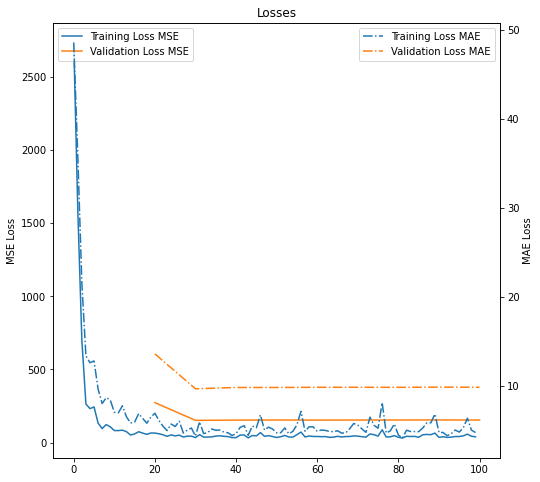

Final average training Losses
40.05571794509888
4.766627391179402
Final average validation Losses
154.21847534179688
9.851483345031738


In [37]:
#Plot loss curves
from matplotlib import pyplot as plt
import numpy as np

mse_train, mae_train = average_logs(loss_train_log)
mse_val,mae_val = average_logs(loss_val_log)


x = np.arange(len(mse_train))

fig = plt.figure(figsize=(8,8))
ax1 = plt.axes()
ax2 = ax1.twinx()
#plt.yscale("log")

ax1.plot(x,mse_train,label = 'Training Loss MSE')
ax2.plot(x,mae_train,label = 'Training Loss MAE',linestyle = '-.')

ax1.plot(epoch_val_log[0][2:],mse_val[2:],label = 'Validation Loss MSE')
ax2.plot(epoch_val_log[0][2:],mae_val[2:],label = 'Validation Loss MAE',linestyle = '-.')

plt.title("Losses")

plt.xlabel("Epoch")
ax1.set_ylabel("MSE Loss")
ax2.set_ylabel("MAE Loss")
ax1.legend(loc = 'upper left')
ax2.legend(loc ='upper right')

plt.show()
plt.close()

print("Final average training Losses")
print(mse_train[-1])
print(mae_train[-1])
print("Final average validation Losses")
print(mse_val[-1])
print(mae_val[-1])


In [9]:
#Run on full dataset:

torch.manual_seed(13) #fixed random seed

img_size = [128, 128, 128]
img_spacing = [1.5, 1.5, 1.5]

num_epochs = 100
learning_rate = 0.01
batch_size = 16
val_interval = 10

out_dir = './output'

# data directory
data_dir = './data/brain_age/'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

meta_data_path_train = 'meta/meta_data_regression_train.csv'
meta_data_path_val = 'meta/meta_data_segmentation_train.csv'


meta_data_seg_train = pd.read_csv(data_dir + meta_data_path_train)
ids_seg_train = list(meta_data_seg_train['subject_id'])
patient_ages_train = meta_data_seg_train['age'] # retrieve patient ages
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + meta_data_path_val)
ids_seg_val = list(meta_data_seg_val['subject_id'])
patient_ages_val = meta_data_seg_val['age'] # retrieve patient ages
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

In [10]:
 # LOAD TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, patient_ages_train, img_spacing, img_size)
# FOR QUICK DEBUGGING, USE THE VALIDATION DATA FOR TRAINING
#dataset_train = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)


# LOAD VALIDATION DATA
dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, patient_ages_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

Loading Data: 100%|██████████| 47/47 [00:25<00:00,  1.88it/s]


In [11]:
model = ResNet18(Block,1,1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size = 10, gamma = 0.1)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)


In [12]:
#Train and Eval
  
loss_train_log = []
loss_val_log = []
epoch_val_log = []
    
print('START TRAINING...')

for epoch in range(1, num_epochs + 1):

    model.train()
    # Training

    loss_train_mse = 0
    loss_train_mae = 0
    loss_train_r2 = 0

    for batch_idx, batch_sample in enumerate(dataloader_train):
        
        batch_images = batch_sample['img']
        batch_targets = batch_sample['age'].float()
        batch_images = batch_images.to(device)
        batch_targets = batch_targets.to(device)
        
        optimizer.zero_grad()
        predictions = model(batch_images)

        loss_mse = F.mse_loss(predictions, batch_targets.reshape((-1,1)))
        loss_mae = F.l1_loss(predictions.detach(), batch_targets.reshape((-1,1))) 
        loss_r2 = r2_score(batch_targets.reshape((-1,1)).cpu().numpy(),predictions.detach().cpu().numpy())   
  

        loss_mse.backward()
        optimizer.step()

        loss_train_mse += loss_mse.item()
        loss_train_mae += loss_mae.item()
        loss_train_r2 += loss_r2

    scheduler.step()
      
    loss_train_mse /= len(dataloader_train)
    loss_train_mae /= len(dataloader_train)
    loss_train_r2 /= len(dataloader_train)

    loss_train_log.append(loss_train_mse)

    print('+ TRAINING \tEpoch: {} \tLoss MSE: {:.6f} \tLoss MAE: {:.6f} \tR2: {:.6f}' .format(epoch, loss_train_mse,loss_train_mae,loss_train_r2))
    
    # Validation
    model.eval()
    if epoch == 1 or epoch % val_interval == 0:
        loss_val_mse = 0
        loss_val_mae = 0
        loss_val_r2 = 0

        with torch.no_grad():
            for data_sample in dataloader_val:
                images = data_sample['img']
                targets = data_sample['age'].float()
                images = images.to(device)
                targets = targets.to(device)

                predictions = model(images)
                loss_val_mse += F.mse_loss(predictions, targets.reshape((-1,1))) 
                loss_val_mae += F.l1_loss(predictions.detach(), targets.reshape((-1,1)))  
                loss_val_r2 +=  r2_score(targets.reshape((-1,1)).cpu().numpy(),predictions.detach().cpu().numpy())     

        loss_val_mse /= len(dataloader_val)
        loss_val_mae /= len(dataloader_val)
        loss_val_r2 /= len(dataloader_val)

        loss_val_log.append(loss_val_mse)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss MSE: {:.6f} \tLoss MAE: {:.6f} \tR2: {:.6f}'.format(epoch, loss_val_mse,loss_val_mae,loss_val_r2))
        print('--------------------------------------------------')

#torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

#plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
#plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
#plt.legend(loc='upper right')
#plt.xlabel('epoch')
#plt.ylabel('loss')
#plt.show()

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss MSE: 621.564499 	Loss MAE: 18.991871 	R2: -0.867999
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss MSE: 97033.054688 	Loss MAE: 310.072693 	R2: -293.225853
--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss MSE: 190.122618 	Loss MAE: 11.108091 	R2: 0.373403
+ TRAINING 	Epoch: 3 	Loss MSE: 177.988632 	Loss MAE: 10.666137 	R2: 0.374583
+ TRAINING 	Epoch: 4 	Loss MSE: 127.112405 	Loss MAE: 9.070548 	R2: 0.595727
+ TRAINING 	Epoch: 5 	Loss MSE: 119.521831 	Loss MAE: 8.880445 	R2: 0.602495
+ TRAINING 	Epoch: 6 	Loss MSE: 112.197563 	Loss MAE: 8.278342 	R2: 0.528560
+ TRAINING 	Epoch: 7 	Loss MSE: 88.103998 	Loss MAE: 7.628800 	R2: 0.682374
+ TRAINING 	Epoch: 8 	Loss MSE: 96.259029 	Loss MAE: 7.920906 	R2: 0.653355
+ TRAINING 	Epoch: 9 	Loss MSE: 76.130285 	Loss MAE: 6.900538 	R2: 0.737648
+ TRAINING 	Epoch: 10 	Loss MSE: 54.586483 	Loss MAE: 5.853145 	R2: 0.826433
-------------------------

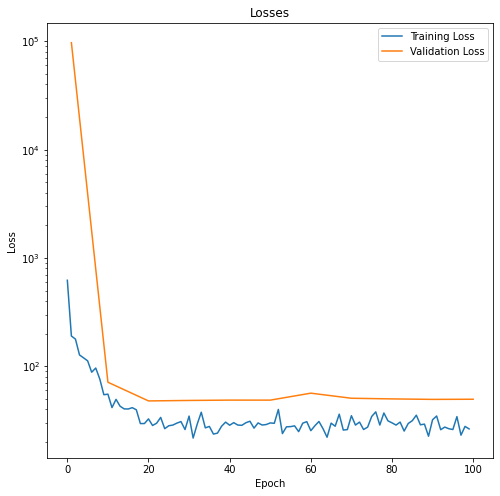

In [18]:
#Plot loss curves
from matplotlib import pyplot as plt
import numpy as np

x = np.arange(len(loss_train_log))

fig = plt.figure(figsize=(8,8))
ax = plt.axes()
plt.yscale("log")

plt.plot(x,loss_train_log,label = 'Training Loss')
plt.plot(epoch_val_log,loss_val_log,label = 'Validation Loss')

plt.title("Losses")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()
plt.close()

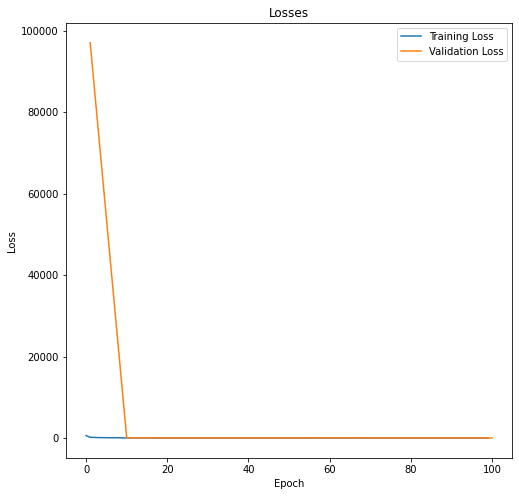

In [19]:
#Plot loss curves
from matplotlib import pyplot as plt
import numpy as np

x = np.arange(len(loss_train_log))

fig = plt.figure(figsize=(8,8))
ax = plt.axes()
#plt.yscale("log")

plt.plot(x,loss_train_log,label = 'Training Loss')
plt.plot(epoch_val_log,loss_val_log,label = 'Validation Loss')

plt.title("Losses")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()
plt.close()

In [20]:
#Run final testing on test data
meta_data_path_test = 'meta/meta_data_regression_test.csv'


meta_data_seg_test = pd.read_csv(data_dir + meta_data_path_test)
ids_seg_test = list(meta_data_seg_test['subject_id'])
patient_ages_test = meta_data_seg_test['age'] # retrieve patient ages
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

In [21]:
# LOAD VALIDATION DATA
dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, patient_ages_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=8, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


In [22]:
    # Validation
model.eval()
    loss_test_mse = 0
    loss_test_mae = 0
    loss_test_r2 = 0

    with torch.no_grad():
        for data_sample in dataloader_test:
            images = data_sample['img']
            targets = data_sample['age'].float()
            images = images.to(device)
            targets = targets.to(device)

            predictions = model(images)
            loss_test_mse += F.mse_loss(predictions, targets.reshape((-1,1))) 
            loss_test_mae += F.l1_loss(predictions.detach(), targets.reshape((-1,1)))
            loss_test_r2 +=  r2_score(targets.reshape((-1,1)).cpu().numpy(),predictions.detach().cpu().numpy())         

    loss_test_mse /= len(dataloader_test)
    loss_test_mae /= len(dataloader_test)
    loss_test_r2 /= len(dataloader_test)

    print('--------------------------------------------------')
    print('+ TESTING \tLoss MSE: {:.6f} \tLoss MAE: {:.6f}'.format(loss_test_mse,loss_test_mae,loss_test_r2))
    print('--------------------------------------------------')

--------------------------------------------------
+ TESTING 	Loss MSE: 56.182671 	Loss MAE: 6.193147
--------------------------------------------------
